[-2.42132727e-15  1.60446641e-16] 5.888568874009003e-30


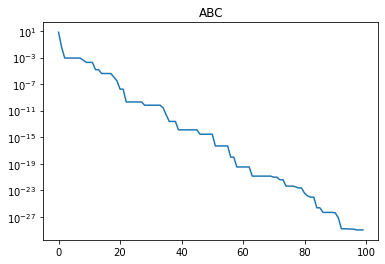

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# 初期設定
N = 100 # 個体数
d = 2 # 次元
TC = np.zeros(N) #更新カウント
lim = 30
xmax = 5
xmin = -5
G = 100 # 繰り返す周期
x = np.zeros((N,d))
for i in range(N):
    x[i] = (xmax-xmin)*np.random.rand(d) + xmin
x_best = x[0] #x_bestの初期化
best = 100 

# ルーレット選択用関数
def roulette_choice(w):
    tot = []
    acc = 0
    for e in w:
        acc += e
        tot.append(acc)

    r = np.random.random() * acc
    for i, e in enumerate(tot):
        if r <= e:
            return i

#目的関数（例としてsphere関数）
def func(x):
    return np.sum(x**2)

# アルゴリズム
best_value = []
for g in range(G):
    best_value.append(func(x_best))

    # employee bee step
    for i in range(N):
        v = x.copy()
        k = i
        while k == i:
            k = np.random.randint(N)


        for j in range(d):
            r = np.random.rand()*2-1 #-1から1までの一様乱数
            v[i,j] = x[i,j] + r * (x[i,j] - x[k,j])

        if func(x[i]) > func(v[i]):
            x[i] = v[i]
            TC[i] = 0
        else: TC[i] += 1

    # onlooker bee step
    for i in range(N):
        w = []
        for j in range(N):
            w.append(np.exp(-func(x[j])))
        i = roulette_choice(w)
        for j in range(d):
            r = np.random.rand()*2-1 #-1から1までの一様乱数
            v[i,j] = x[i,j] + r * (x[i,j] - x[k,j])
        if func(x[i]) > func(v[i]):
            x[i] = v[i]
            TC[i] = 0
        else: TC[i] += 1

    # scout bee step
    for i in range(N):
        if TC[i] > lim:
            for j in range(d):
                x[i,j] = np.random.rand()*(xmax-xmin) + xmin
            TC[i] = 0

    # 最良個体の発見
    for i in range(N):
        if best > func(x[i]):
            x_best = x[i]
            best = func(x_best)

print(x_best,func(x_best))
plt.plot(range(G),best_value)
plt.yscale('log')
plt.title("ABC")
plt.show()

In [17]:
def opt_mpc_with_state_constr(A, B, N, Q, R, P, x0, xmin=None, xmax=None, umax=None, umin=None):
    """
    optimize MPC problem with state and (or) input constraints

    return
        x: state
        u: input
    """
    (nx, nu) = B.shape

    H = scipy.linalg.block_diag(np.kron(np.eye(N), R), np.kron(np.eye(N - 1), Q), np.eye(P.shape[0]))

    # calc Ae
    Aeu = np.kron(np.eye(N), -B)
    Aex = scipy.linalg.block_diag(np.eye((N - 1) * nx), P)
    Aex -= np.kron(np.diag([1.0] * (N - 1), k=-1), A)
    Ae = np.hstack((Aeu, Aex))

    # calc be
    be = np.vstack((A, np.zeros(((N - 1) * nx, nx)))) * x0
    #  print(be)

    # === optimization ===
    P = matrix(H)
    q = matrix(np.zeros((N * nx + N * nu, 1)))
    A = matrix(Ae)
    b = matrix(be)

    if umax is None and umin is None:
        sol = cvxopt.solvers.qp(P, q, A=A, b=b)
    else:
        G, h = generate_inequalities_constraints_mat(N, nx, nu, xmin, xmax, umin, umax)

        G = matrix(G)
        h = matrix(h)

        sol = cvxopt.solvers.qp(P, q, G, h, A=A, b=b)

    fx = np.matrix(sol["x"])

    u = fx[0:N * nu].reshape(N, nu).T

    x = fx[-N * nx:].reshape(N, nx).T
    x = np.hstack((x0, x))

    return x, u

def generate_inequalities_constraints_mat(N, nx, nu, xmin, xmax, umin, umax):
    """
    generate matrices of inequalities constrints

    return G, h
    """
    G = np.zeros((0, (nx + nu) * N))
    h = np.zeros((0, 1))
    if umax is not None:
        tG = np.hstack([np.eye(N * nu), np.zeros((N * nu, nx * N))])
        th = np.kron(np.ones((N * nu, 1)), umax)
        G = np.vstack([G, tG])
        h = np.vstack([h, th])

    if umin is not None:
        tG = np.hstack([np.eye(N * nu) * -1.0, np.zeros((N * nu, nx * N))])
        th = np.kron(np.ones((N, 1)), umin * -1.0)
        G = np.vstack([G, tG])
        h = np.vstack([h, th])

    if xmax is not None:
        tG = np.hstack([np.zeros((N * nx, nu * N)), np.eye(N * nx)])
        th = np.kron(np.ones((N, 1)), xmax)
        G = np.vstack([G, tG])
        h = np.vstack([h, th])

    if xmin is not None:
        tG = np.hstack([np.zeros((N * nx, nu * N)), np.eye(N * nx) * -1.0])
        th = np.kron(np.ones((N, 1)), xmin * -1.0)
        G = np.vstack([G, tG])
        h = np.vstack([h, th])

    return G, h